In [5]:
%load_ext autoreload
%autoreload 2

import torch 
import os
import glob
from matplotlib import pyplot as plt

import matplotlib.animation as animation
import os
import torch
import numpy as np
import pandas as pd
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')


from distributions import ZeroInflatedDist, QuantizedNormal
from torch_models import MixtureOfTruncNormModel, SpatialWaves
from torch_training import train_epoch
from torch_perturb.torch_pert_topk import PerturbedTopK

from torch_models import torch_bpr_uncurried, deterministic_bpr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
deaths = pd.read_csv('deaths1.csv')
pop = pd.read_csv('pop1.csv')

In [7]:
data_shape = (25, 56)

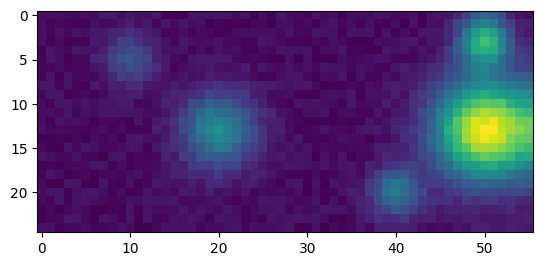

In [8]:
plt.imshow(pop['pop'].values.reshape(data_shape))

In [10]:
model = SpatialWaves(num_waves=1,low=0, high=1000000)

In [11]:
# turn the death column into a time-by-geoid array
deaths_TS = deaths.pivot(index='time', columns='geoid', values='death').values
pop_S = pop['pop'].values

# create latitude and longitude arrays corresponding to the row and column index of the geoids when reshaped into data_shape
lat = np.linspace(25, 50, data_shape[0])
lon = np.linspace(-125, -65, data_shape[1])
lat_S, lon_S = np.meshgrid(lon, lat)
lat_S = lat_S.flatten()
lon_S = lon_S.flatten()
# create column of time values
time_T = np.arange(deaths_TS.shape[0])

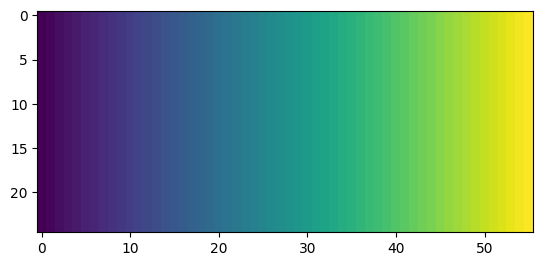

In [12]:
plt.imshow(lat_S.reshape(data_shape))

In [13]:
time_T = torch.tensor(time_T, dtype=torch.float32)
lat_S = torch.tensor(lat_S, dtype=torch.float32)
lon_S = torch.tensor(lon_S, dtype=torch.float32)
pop_S = torch.tensor(pop_S, dtype=torch.float32)
S = pop_S.shape[0]
T = time_T.shape[0]
W = 2

In [14]:
arrival_times_SW = model.arrival_intercepts.expand(S,W) +lat_S.unsqueeze(-1)*model.lat_coeff.expand(1,W) + lon_S.unsqueeze(-1)*model.lon_coeff.expand(1,W)
# exponentiate time - arrival time / peak width
time_diff_TSW = time_T.unsqueeze(-1).unsqueeze(-1) - arrival_times_SW.expand(1,S,W)
# square time_diff/peak_width
magnitudes_W = torch.nn.functional.softplus(model.softplusinv_magnitudes)
peak_widths_W = torch.nn.functional.softplus(model.softplusinv_peak_widths) + model.min_peak_width
waves_TSW = magnitudes_W.expand(1,1,W)*torch.exp(-(time_diff_TSW/peak_widths_W.expand(1,1,W))**2)
death_rate_TS = torch.sum(waves_TSW, dim=-1)
mean_deaths_TS = pop_S.expand(1,S)*death_rate_TS

In [15]:
magnitudes_W.min()

tensor(1.0963, grad_fn=<MinBackward1>)

In [16]:
dist = model(time_T,pop_S, lat_S, lon_S)

In [17]:
M_score_func = 20
M_action = 20

In [18]:
y_sample_TMS = dist.sample((M_score_func, )).permute(1, 0, 2)
y_sample_action_TMS = dist.sample((M_action, )).permute(1, 0, 2)
ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
ratio_rating_TS.requires_grad_(True)

def get_log_probs_baked(param):
    distribution = model.build_from_single_tensor(param, time_T, pop_S, lat_S, lon_S)
    log_probs_TMS = distribution.log_prob(y_sample_TMS.permute(1, 0, 2)).permute(1, 0, 2)

    return log_probs_TMS
jac_TMSP = torch.autograd.functional.jacobian(get_log_probs_baked, (model.params_to_single_tensor()), strategy='forward-mode', vectorize=True)

score_func_estimator_TMSP = jac_TMSP * ratio_rating_TMS.unsqueeze(-1)
score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)    


In [19]:
jac_TMSP.max()

tensor(416867.5938, grad_fn=<MaxBackward1>)

In [20]:
K=100
threshold=0.8
bpr_weight, nll_weight = 1,1

In [21]:
perturbed_top_K_func = PerturbedTopK(k=K, sigma=0.05, num_samples=20)

In [22]:
prob_topk_TKS = perturbed_top_K_func(ratio_rating_TS)

In [23]:
# Apply perturbed_top_K_func  to each row of ratio_rating_TS in a loop
prob_topk_TKS = torch.zeros(T, K, S)
for t in range(T):
    prob_topk_TKS[t] = perturbed_top_K_func(torch.unsqueeze(ratio_rating_TS[t,:],0))

In [24]:
# Sum over k dim
top_K_ids = prob_topk_TKS.sum(dim=-2)

true_top_K_val, _  = torch.topk(torch.tensor(deaths_TS), K) 
denominator = torch.sum(true_top_K_val, dim=-1)
numerator = torch.sum(top_K_ids * torch.tensor(deaths_TS), dim=-1)
positive_bpr_T = numerator/denominator

In [25]:
bpr_threshold_diff_T = positive_bpr_T - threshold
violate_threshold_flag = bpr_threshold_diff_T < 0
negative_bpr_loss = torch.mean(-bpr_threshold_diff_T*violate_threshold_flag)

In [26]:
nll = torch.mean(-dist.log_prob( torch.tensor(deaths_TS)))

In [27]:
loss = bpr_weight*negative_bpr_loss + nll_weight*nll
loss.backward()


In [ ]:
loss_grad_TS = ratio_rating_TS.grad

In [ ]:
loss_grad_TS

tensor([[-1.0505e-02, -8.1449e-03,  9.2589e-03,  ..., -7.5080e-04,
         -8.0343e-03,  1.2063e-02],
        [ 4.8732e-04, -4.4626e-03,  7.2772e-03,  ...,  7.1460e-03,
          4.3653e-05,  3.6807e-03],
        [ 4.9690e-03, -1.3609e-03,  8.5682e-03,  ...,  4.9992e-03,
          4.9711e-03, -7.8694e-03],
        ...,
        [ 1.0026e-02,  3.9086e-03, -5.7616e-03,  ...,  1.3390e-03,
         -6.1598e-03,  6.2293e-03],
        [ 2.1062e-03, -4.6391e-03, -3.7959e-03,  ...,  6.7627e-03,
         -1.8589e-04, -1.8640e-02],
        [-2.3724e-02, -1.0309e-02,  4.3863e-04,  ..., -1.4426e-02,
         -7.0322e-03, -5.3227e-03]])

In [24]:
# find index where y_TMS is -inf
inf_index = torch.isinf(y_sample_TMS)
index_vals = torch.nonzero(inf_index, as_tuple=True)

In [16]:
y_sample_TMS[0,:,108]

tensor([0.2843, 0.0123, 0.3165, 0.2909, 0.0777, 0.0268, 0.0432, 0.1098, 0.2158,
        0.1625, 0.0204, 0.0755, 0.0734, 0.0210, 0.1243, 0.2230, 0.0527, 0.0151,
        0.1909, 0.2483])

In [256]:
mean_deaths_TS[0,108]

tensor(0.0010, grad_fn=<SelectBackward0>)